## Introduction to Hidden Markov Models with Python Networkx and Sklearn


<br>Author: Rakib Al-Fahad 
<br>Phd Candidate 
<br>The University of Memphis 
<br>Memphis, Tennessee 
<br>email: ralfahad@memphis.edu 
https://rakibalfahad.github.io/


### Ref:
http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017

## What is the Markov Property?

"...a random process where the future is independent of the past given the present."


Assume a simplified coin toss game with a fair coin. Suspend disbelief and assume that the Markov property is not yet known and we would like to predict the probability of flipping heads after 10 flips. Under the assumption of conditional dependence (the coin has memory of past states and the future state depends on the sequence of past states) we must record the specific sequence that lead up to the 11th flip and the joint probabilities of those flips. So imagine after 10 flips we have a random sequence of heads and tails. The joint probability of that sequence is 0.5^10 = 0.0009765625. Under conditional dependence, the probability of heads on the next flip is 0.0009765625 * 0.5 = 0.00048828125. 

Is that the real probability of flipping heads on the 11th flip? Hell no!

We know that the event of flipping the coin does not depend on the result of the flip before it. The coin has no memory. The process of successive flips does not encode the prior results. Each flip is a unique event with equal probability of heads or tails, aka conditionally independent of past states. This is the Markov property.  

## What is a Markov Model?

A Markov chain (model) describes a stochastic process where the assumed probability of future state(s) depends only on the current process state and not on any the states that preceded it (shocker).

Let's get into a simple example. Assume you want to model the future probability that your dog is in one of three states given its current state. To do this <font color='red'>we need to specify the state space, the initial probabilities, and the transition probabilities.</font>

Imagine you have a very lazy fat dog, so we **define the state space as sleeping, eating, or pooping. We will set the initial probabilities to 35%, 35%, and 30% respectively.**

In [1]:
## PC config

%load_ext watermark
%watermark

2018-11-13T14:49:52

CPython 2.7.15
IPython 5.8.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 24
interpreter: 64bit


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# create state space and initial state probabilities

states = ['sleeping', 'eating', 'pooping']
pi = [0.35, 0.35, 0.3]
state_space = pd.Series(pi, index=states, name='states')
print(state_space)
print(state_space.sum())

sleeping    0.35
eating      0.35
pooping     0.30
Name: states, dtype: float64
1.0


The next step is to **define the transition probabilities**. They are simply the probabilities of staying in the same state or moving to a different state given the current state. 

In [3]:
# create transition matrix
# equals transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.4, 0.2, 0.4]
q_df.loc[states[1]] = [0.45, 0.45, 0.1]
q_df.loc[states[2]] = [0.45, 0.25, .3]

q = q_df.values
print('\n', q, q.shape, '\n')
print(q_df.sum(axis=1))

q_df

('\n', array([[0.4, 0.2, 0.4],
       [0.45, 0.45, 0.1],
       [0.45, 0.25, 0.3]], dtype=object), (3, 3), '\n')
sleeping    1.0
eating      1.0
pooping     1.0
dtype: float64


,sleeping,eating,pooping
sleeping,0.4,0.2,0.4
eating,0.45,0.45,0.1
pooping,0.45,0.25,0.3


Now that we have the initial and transition probabilities setup we can create a **Markov diagram using the Networkx package.**

To do this requires a little bit of flexible thinking. Networkx creates Graphs that consist of nodes and edges. In our toy example the dog's possible states are the nodes and the edges are the lines that connect the nodes. The transition probabilities are the weights. They represent the probability of transitioning to a state given the current state.

Something to note is networkx deals primarily with dictionary objects. With that said, we need to create a dictionary object that holds our edges and their weights.

In [4]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('eating', 'eating'): 0.45,
 ('eating', 'pooping'): 0.1,
 ('eating', 'sleeping'): 0.45,
 ('pooping', 'eating'): 0.25,
 ('pooping', 'pooping'): 0.3,
 ('pooping', 'sleeping'): 0.45,
 ('sleeping', 'eating'): 0.2,
 ('sleeping', 'pooping'): 0.4,
 ('sleeping', 'sleeping'): 0.4}


## You will need pydot

To install this package with conda run:
 "conda install -c anaconda pydot"

OutMultiEdgeDataView([('eating', 'eating', {'weight': 0.45, 'label': 0.45}), ('eating', 'pooping', {'weight': 0.1, 'label': 0.1}), ('eating', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('pooping', 'eating', {'weight': 0.25, 'label': 0.25}), ('pooping', 'pooping', {'weight': 0.3, 'label': 0.3}), ('pooping', 'sleeping', {'weight': 0.45, 'label': 0.45}), ('sleeping', 'eating', {'weight': 0.2, 'label': 0.2}), ('sleeping', 'pooping', {'weight': 0.4, 'label': 0.4}), ('sleeping', 'sleeping', {'weight': 0.4, 'label': 0.4})])


,sleeping,eating,pooping
sleeping,0.4,0.2,0.4
eating,0.45,0.45,0.1
pooping,0.45,0.25,0.3


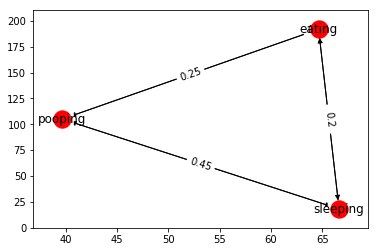

In [5]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)
#print(r'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
#print('Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_markov.dot')

q_df

## Graphviz visualization

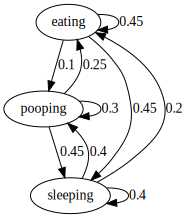

In [6]:
import graphviz

with open("pet_dog_markov.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

## What Makes a Markov Model Hidden?
Consider a situation where your dog is acting strangely and **you wanted to model the probability that your dog's behavior is due to sickness or simply quirky behavior when otherwise healthy.**

In this situation the true state of the dog is unknown, thus hidden from you. One way to model this is to assume that the dog has observable behaviors that represent the true, hidden state. Let's walk through an example.

***First we create our state space - healthy or sick. We assume they are equiprobable.***  

In [7]:
# create state space and initial state probabilities

hidden_states = ['healthy', 'sick']
pi = [0.5, 0.5]
state_space = pd.Series(pi, index=hidden_states, name='states')
print(state_space)
print(state_space.sum())

healthy    0.5
sick       0.5
Name: states, dtype: float64
1.0


## We create our transition matrix for the hidden states.

In [8]:
# create hidden transition matrix
# a or alpha 
#   = transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7, 0.3]
a_df.loc[hidden_states[1]] = [0.4, 0.6]

a_df

# a = a_df.values

# print(a, a.shape, '\n')
# print(a_df.sum(axis=1))

,healthy,sick
healthy,0.7,0.3
sick,0.4,0.6


This is where it gets a little more interesting. Now we create the **emission or observation probability matrix. This matrix is size M x O where M is the number of hidden states and O is the number of possible observable states.** 

The emission matrix tells us the probability the dog is in one of the hidden states, given the current, observable state. 

Let's keep the same observable states from the previous example. The dog can be either sleeping, eating, or pooping. For now we make our best guess to fill in the probabilities. from mpl_finance import quotes_historical_yahoo

In [10]:
# create matrix of observation (emission) probabilities
# b or beta = observation probabilities given state
# matrix is size (M x O) where M is number of states 
# and O is number of different possible observations

observable_states = states

b_df = pd.DataFrame(columns=observable_states, index=hidden_states)
b_df.loc[hidden_states[0]] = [0.2, 0.6, 0.2]
b_df.loc[hidden_states[1]] = [0.4, 0.1, 0.5]

b_df


,sleeping,eating,pooping
healthy,0.2,0.6,0.2
sick,0.4,0.1,0.5


Now we create the graph edges and the graph object. 

In [11]:
# create graph edges and weights

hide_edges_wts = _get_markov_edges(a_df)
pprint(hide_edges_wts)

emit_edges_wts = _get_markov_edges(b_df)
pprint(emit_edges_wts)

{('healthy', 'healthy'): 0.7,
 ('healthy', 'sick'): 0.3,
 ('sick', 'healthy'): 0.4,
 ('sick', 'sick'): 0.6}
{('healthy', 'eating'): 0.6,
 ('healthy', 'pooping'): 0.2,
 ('healthy', 'sleeping'): 0.2,
 ('sick', 'eating'): 0.1,
 ('sick', 'pooping'): 0.5,
 ('sick', 'sleeping'): 0.4}


OutMultiEdgeDataView([('healthy', 'healthy', {'weight': 0.7, 'label': 0.7}), ('healthy', 'eating', {'weight': 0.6, 'label': 0.6}), ('healthy', 'pooping', {'weight': 0.2, 'label': 0.2}), ('healthy', 'sick', {'weight': 0.3, 'label': 0.3}), ('healthy', 'sleeping', {'weight': 0.2, 'label': 0.2}), ('sick', 'healthy', {'weight': 0.4, 'label': 0.4}), ('sick', 'eating', {'weight': 0.1, 'label': 0.1}), ('sick', 'pooping', {'weight': 0.5, 'label': 0.5}), ('sick', 'sick', {'weight': 0.6, 'label': 0.6}), ('sick', 'sleeping', {'weight': 0.4, 'label': 0.4})])


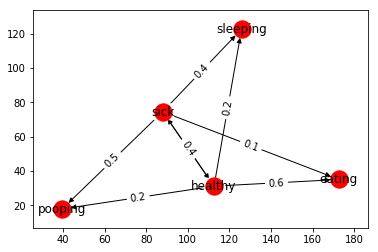

In [13]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(hidden_states)
#print(f'Nodes:\n{G.nodes()}\n')

# edges represent hidden probabilities
for k, v in hide_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)

# edges represent emission probabilities
for k, v in emit_edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
    
#print(f'Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='neato')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
emit_edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=emit_edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'pet_dog_hidden_markov.dot')

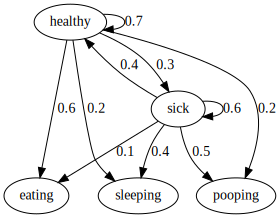

In [14]:

with open("pet_dog_hidden_markov.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

The hidden Markov graph is a little more complex but the principles are the same. For example, you would expect that if your dog is eating there is a high probability that it is healthy (60%) and a very low probability that the dog is sick (10%).

Now, what if you needed to discern the health of your dog over time given a sequence of observations?  

In [15]:
# observation sequence of dog's behaviors
# observations are encoded numerically

obs_map = {'sleeping':0, 'eating':1, 'pooping':2}
obs = np.array([1,1,2,1,0,1,2,1,0,2,2,0,1,0,1])

inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print( pd.DataFrame(np.column_stack([obs, obs_seq]), 
                columns=['Obs_code', 'Obs_seq']) )

   Obs_code   Obs_seq
0         1    eating
1         1    eating
2         2   pooping
3         1    eating
4         0  sleeping
5         1    eating
6         2   pooping
7         1    eating
8         0  sleeping
9         2   pooping
10        2   pooping
11        0  sleeping
12        1    eating
13        0  sleeping
14        1    eating


Using the **Viterbi algorithm** we can identify the most likely sequence of hidden states given the sequence of observations.

High level, the Viterbi algorithm increments over each time step, finding the maximum probability of any path that gets to state iat time t, that also has the correct observations for the sequence up to time t.

The algorithm also keeps track of the state with the highest probability at each stage. At the end of the sequence, the algorithm will iterate backwards selecting the state that "won" each time step, and thus creating the most likely path, or likely sequence of hidden states that led to the sequence of observations.

In [16]:
# define Viterbi algorithm for shortest path
# code adapted from Stephen Marsland's, Machine Learning An Algorthmic Perspective, Vol. 2
# https://github.com/alexsosn/MarslandMLAlgo/blob/master/Ch16/HMM.py

def viterbi(pi, a, b, obs):
    
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    
    # init blank path
    path = np.zeros(T)
    # delta --> highest probability of any path that reaches state i
    delta = np.zeros((nStates, T))
    # phi --> argmax by time step for each state
    phi = np.zeros((nStates, T))
    
    # init delta and phi 
    delta[:, 0] = pi * b[:, obs[0]]
    phi[:, 0] = 0

    print('Start Walk Forward \n')    
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    print('-'*50)
    print('Start Backtrace\n')
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        path[t] = phi[path[t+1], [t+1]]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi

path, delta, phi = viterbi(pi, a, b, obs)
print('\nsingle best state path: \n', path)
print('delta:\n', delta)
print('phi:\n', phi)

NameError: name 'a' is not defined

In [17]:
import numpy as np
from sklearn import hmm

startprob = np.array([0.6, 0.3, 0.1])
transmat = np.array([[0.7, 0.2, 0.1], [0.3, 0.5, 0.2], [0.3, 0.3, 0.4]])
#means = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
#covars = np.tile(np.identity(2), (3, 1, 1))
model = hmm.GaussianHMM(3, "full", startprob, transmat)
model.means_ = means
model.covars_ = covars
X, Z = model.sample(100)

ImportError: cannot import name hmm

In [18]:
import bnpy
import numpy as np
import os
from matplotlib import pylab
import seaborn as sns
SMALL_FIG_SIZE = (2.5, 2.5)
FIG_SIZE = (5, 5)
pylab.rcParams['figure.figsize'] = FIG_SIZE

In [19]:
dataset_path = os.path.join(bnpy.DATASET_PATH, 'mocap6')
dataset = bnpy.data.GroupXData.read_npz(
os.path.join(dataset_path, 'dataset.npz'))

In [23]:
dataset.X[7].shape

(12,)

In [25]:
def show_single_sequence(seq_id):
    start = dataset.doc_range[seq_id]
    stop = dataset.doc_range[seq_id + 1]
    for dim in xrange(12):
        X_seq = dataset.X[start:stop]
        pylab.plot(X_seq[:, dim], '.-')
        pylab.xlabel('time')
        pylab.ylabel('angle')
        pylab.tight_layout()

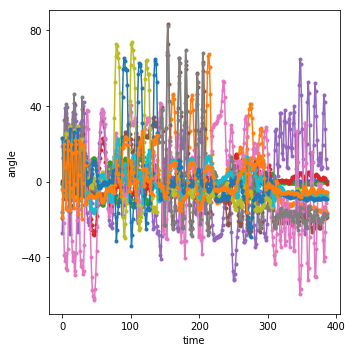

In [28]:
show_single_sequence(5)

In [36]:

alpha = 0.5
gamma = 5.0
sF = 1.0
K = 12

mixdiag_trained_model, mixdiag_info_dict = bnpy.run(
dataset, 'DPMixtureModel', 'DiagGauss', 'soVB',
output_path='/tmp/mocap6/showcase-K=20-model=DP+DiagGauss-ECovMat=1*eye/',
nLap=500, nTask=1, nBatch=1, convergeThr=0.01,
alpha=alpha, gamma=gamma, sF=sF, ECovMat='eye',
K=K, initname='randexamples',
)

  --convergeThr
  --alpha
Dataset Summary:
GroupXData
  total size: 6 units
  batch size: 6 units
  num. batches: 1
Allocation Model:  DP mixture with K=0. Concentration gamma0= 5.00
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 14  ...
  beta = [ 12  12]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 12 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: soVB | task  1/10 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=DP+DiagGauss-ECovMat=1*eye/1
    1.000/500 after      0 sec. |    172.4 MiB | K   12 | loss  3.827303094e+00 |  lrate 0.7071
    2.000/500 after      0 sec. |    172.4 MiB | K   12 | loss  3.750127946e+00 |  lrate 0.5774
    3.000/500 after      0 sec. |    172.4 MiB | K   12 | loss  3.732842315e+00 | 

   79.000/500 after      1 sec. |    172.4 MiB | K   12 | loss  3.653708350e+00 |  lrate 0.1118
   80.000/500 after      1 sec. |    172.4 MiB | K   12 | loss  3.653629030e+00 |  lrate 0.1111
   81.000/500 after      1 sec. |    172.4 MiB | K   12 | loss  3.653557191e+00 |  lrate 0.1104
   82.000/500 after      1 sec. |    172.4 MiB | K   12 | loss  3.653491988e+00 |  lrate 0.1098
   83.000/500 after      1 sec. |    172.4 MiB | K   12 | loss  3.653432682e+00 |  lrate 0.1091
   84.000/500 after      1 sec. |    172.4 MiB | K   12 | loss  3.653378627e+00 |  lrate 0.1085
   85.000/500 after      1 sec. |    172.4 MiB | K   12 | loss  3.653329256e+00 |  lrate 0.1078
   86.000/500 after      1 sec. |    172.4 MiB | K   12 | loss  3.653284068e+00 |  lrate 0.1072
   87.000/500 after      1 sec. |    172.4 MiB | K   12 | loss  3.653242624e+00 |  lrate 0.1066
   88.000/500 after      1 sec. |    172.4 MiB | K   12 | loss  3.653204537e+00 |  lrate 0.1060
   89.000/500 after      1 sec. |    172

  165.000/500 after      2 sec. |    172.4 MiB | K   12 | loss  3.651677302e+00 |  lrate 0.0776
  166.000/500 after      2 sec. |    172.4 MiB | K   12 | loss  3.651653739e+00 |  lrate 0.0774
  167.000/500 after      2 sec. |    172.4 MiB | K   12 | loss  3.651630359e+00 |  lrate 0.0772
  168.000/500 after      2 sec. |    172.4 MiB | K   12 | loss  3.651607177e+00 |  lrate 0.0769
  169.000/500 after      2 sec. |    172.4 MiB | K   12 | loss  3.651584204e+00 |  lrate 0.0767
  170.000/500 after      2 sec. |    172.4 MiB | K   12 | loss  3.651561455e+00 |  lrate 0.0765
  171.000/500 after      3 sec. |    172.4 MiB | K   12 | loss  3.651538944e+00 |  lrate 0.0762
  172.000/500 after      3 sec. |    172.4 MiB | K   12 | loss  3.651516687e+00 |  lrate 0.0760
  173.000/500 after      3 sec. |    172.4 MiB | K   12 | loss  3.651494698e+00 |  lrate 0.0758
  174.000/500 after      3 sec. |    172.4 MiB | K   12 | loss  3.651472993e+00 |  lrate 0.0756
  175.000/500 after      3 sec. |    172

  251.000/500 after      4 sec. |    172.4 MiB | K   12 | loss  3.650323997e+00 |  lrate 0.0630
  252.000/500 after      4 sec. |    172.4 MiB | K   12 | loss  3.650320643e+00 |  lrate 0.0629
  253.000/500 after      4 sec. |    172.4 MiB | K   12 | loss  3.650317529e+00 |  lrate 0.0627
  254.000/500 after      4 sec. |    172.4 MiB | K   12 | loss  3.650314637e+00 |  lrate 0.0626
  255.000/500 after      4 sec. |    172.4 MiB | K   12 | loss  3.650311948e+00 |  lrate 0.0625
  256.000/500 after      4 sec. |    172.4 MiB | K   12 | loss  3.650309446e+00 |  lrate 0.0624
  257.000/500 after      4 sec. |    172.4 MiB | K   12 | loss  3.650307117e+00 |  lrate 0.0623
  258.000/500 after      4 sec. |    172.4 MiB | K   12 | loss  3.650304946e+00 |  lrate 0.0621
  259.000/500 after      4 sec. |    172.4 MiB | K   12 | loss  3.650302921e+00 |  lrate 0.0620
  260.000/500 after      4 sec. |    172.4 MiB | K   12 | loss  3.650301030e+00 |  lrate 0.0619
  261.000/500 after      4 sec. |    172

  337.000/500 after      5 sec. |    172.4 MiB | K   12 | loss  3.650267253e+00 |  lrate 0.0544
  338.000/500 after      5 sec. |    172.4 MiB | K   12 | loss  3.650267167e+00 |  lrate 0.0543
  339.000/500 after      5 sec. |    172.4 MiB | K   12 | loss  3.650267082e+00 |  lrate 0.0542
  340.000/500 after      5 sec. |    172.4 MiB | K   12 | loss  3.650266999e+00 |  lrate 0.0542
  341.000/500 after      5 sec. |    172.4 MiB | K   12 | loss  3.650266918e+00 |  lrate 0.0541
  342.000/500 after      5 sec. |    172.4 MiB | K   12 | loss  3.650266838e+00 |  lrate 0.0540
  343.000/500 after      5 sec. |    172.4 MiB | K   12 | loss  3.650266761e+00 |  lrate 0.0539
  344.000/500 after      5 sec. |    172.4 MiB | K   12 | loss  3.650266684e+00 |  lrate 0.0538
  345.000/500 after      5 sec. |    172.4 MiB | K   12 | loss  3.650266610e+00 |  lrate 0.0538
  346.000/500 after      5 sec. |    172.4 MiB | K   12 | loss  3.650266536e+00 |  lrate 0.0537
  347.000/500 after      5 sec. |    172

  423.000/500 after      6 sec. |    172.4 MiB | K   12 | loss  3.650263323e+00 |  lrate 0.0486
  424.000/500 after      6 sec. |    172.4 MiB | K   12 | loss  3.650263299e+00 |  lrate 0.0485
  425.000/500 after      6 sec. |    172.4 MiB | K   12 | loss  3.650263275e+00 |  lrate 0.0485
  426.000/500 after      6 sec. |    172.4 MiB | K   12 | loss  3.650263251e+00 |  lrate 0.0484
  427.000/500 after      6 sec. |    172.4 MiB | K   12 | loss  3.650263227e+00 |  lrate 0.0483
  428.000/500 after      6 sec. |    172.4 MiB | K   12 | loss  3.650263204e+00 |  lrate 0.0483
  429.000/500 after      6 sec. |    172.4 MiB | K   12 | loss  3.650263181e+00 |  lrate 0.0482
  430.000/500 after      6 sec. |    172.4 MiB | K   12 | loss  3.650263158e+00 |  lrate 0.0482
  431.000/500 after      6 sec. |    172.4 MiB | K   12 | loss  3.650263136e+00 |  lrate 0.0481
  432.000/500 after      6 sec. |    172.4 MiB | K   12 | loss  3.650263114e+00 |  lrate 0.0481
  433.000/500 after      6 sec. |    172

    7.000/500 after      0 sec. |    172.9 MiB | K   12 | loss  3.742809880e+00 |  lrate 0.3536
    8.000/500 after      0 sec. |    172.9 MiB | K   12 | loss  3.738314072e+00 |  lrate 0.3333
    9.000/500 after      0 sec. |    172.9 MiB | K   12 | loss  3.734364766e+00 |  lrate 0.3162
   10.000/500 after      0 sec. |    172.9 MiB | K   12 | loss  3.731149775e+00 |  lrate 0.3015
   11.000/500 after      0 sec. |    172.9 MiB | K   12 | loss  3.728420548e+00 |  lrate 0.2887
   12.000/500 after      0 sec. |    172.9 MiB | K   12 | loss  3.725795219e+00 |  lrate 0.2774
   13.000/500 after      0 sec. |    172.9 MiB | K   12 | loss  3.723094214e+00 |  lrate 0.2673
   14.000/500 after      0 sec. |    172.9 MiB | K   12 | loss  3.720562106e+00 |  lrate 0.2582
   15.000/500 after      0 sec. |    172.9 MiB | K   12 | loss  3.718723872e+00 |  lrate 0.2500
   16.000/500 after      0 sec. |    172.9 MiB | K   12 | loss  3.717410930e+00 |  lrate 0.2425
   17.000/500 after      0 sec. |    172

   93.000/500 after      1 sec. |    172.9 MiB | K   12 | loss  3.709409291e+00 |  lrate 0.1031
   94.000/500 after      1 sec. |    172.9 MiB | K   12 | loss  3.709393838e+00 |  lrate 0.1026
   95.000/500 after      1 sec. |    172.9 MiB | K   12 | loss  3.709379227e+00 |  lrate 0.1021
   96.000/500 after      1 sec. |    172.9 MiB | K   12 | loss  3.709365395e+00 |  lrate 0.1015
   97.000/500 after      1 sec. |    172.9 MiB | K   12 | loss  3.709352284e+00 |  lrate 0.1010
   98.000/500 after      1 sec. |    172.9 MiB | K   12 | loss  3.709339842e+00 |  lrate 0.1005
   99.000/500 after      1 sec. |    172.9 MiB | K   12 | loss  3.709328018e+00 |  lrate 0.1000
  100.000/500 after      1 sec. |    172.9 MiB | K   12 | loss  3.709316770e+00 |  lrate 0.0995
  101.000/500 after      1 sec. |    172.9 MiB | K   12 | loss  3.709306054e+00 |  lrate 0.0990
  102.000/500 after      1 sec. |    172.9 MiB | K   12 | loss  3.709295835e+00 |  lrate 0.0985
  103.000/500 after      1 sec. |    172

  179.000/500 after      2 sec. |    172.9 MiB | K   12 | loss  3.709062757e+00 |  lrate 0.0745
  180.000/500 after      2 sec. |    172.9 MiB | K   12 | loss  3.709062333e+00 |  lrate 0.0743
  181.000/500 after      2 sec. |    172.9 MiB | K   12 | loss  3.709061924e+00 |  lrate 0.0741
  182.000/500 after      2 sec. |    172.9 MiB | K   12 | loss  3.709061530e+00 |  lrate 0.0739
  183.000/500 after      2 sec. |    172.9 MiB | K   12 | loss  3.709061149e+00 |  lrate 0.0737
  184.000/500 after      2 sec. |    172.9 MiB | K   12 | loss  3.709060782e+00 |  lrate 0.0735
  185.000/500 after      2 sec. |    172.9 MiB | K   12 | loss  3.709060427e+00 |  lrate 0.0733
  186.000/500 after      2 sec. |    172.9 MiB | K   12 | loss  3.709060084e+00 |  lrate 0.0731
  187.000/500 after      2 sec. |    172.9 MiB | K   12 | loss  3.709059754e+00 |  lrate 0.0729
  188.000/500 after      2 sec. |    172.9 MiB | K   12 | loss  3.709059434e+00 |  lrate 0.0727
  189.000/500 after      2 sec. |    172

  265.000/500 after      3 sec. |    172.9 MiB | K   12 | loss  3.709050092e+00 |  lrate 0.0613
  266.000/500 after      3 sec. |    172.9 MiB | K   12 | loss  3.709050056e+00 |  lrate 0.0612
  267.000/500 after      3 sec. |    172.9 MiB | K   12 | loss  3.709050021e+00 |  lrate 0.0611
  268.000/500 after      3 sec. |    172.9 MiB | K   12 | loss  3.709049987e+00 |  lrate 0.0610
  269.000/500 after      3 sec. |    172.9 MiB | K   12 | loss  3.709049954e+00 |  lrate 0.0609
  270.000/500 after      3 sec. |    172.9 MiB | K   12 | loss  3.709049921e+00 |  lrate 0.0607
  271.000/500 after      3 sec. |    172.9 MiB | K   12 | loss  3.709049890e+00 |  lrate 0.0606
  272.000/500 after      3 sec. |    172.9 MiB | K   12 | loss  3.709049859e+00 |  lrate 0.0605
  273.000/500 after      3 sec. |    172.9 MiB | K   12 | loss  3.709049828e+00 |  lrate 0.0604
  274.000/500 after      3 sec. |    172.9 MiB | K   12 | loss  3.709049799e+00 |  lrate 0.0603
  275.000/500 after      3 sec. |    172

  351.000/500 after      4 sec. |    172.9 MiB | K   12 | loss  3.709048749e+00 |  lrate 0.0533
  352.000/500 after      4 sec. |    172.9 MiB | K   12 | loss  3.709048744e+00 |  lrate 0.0532
  353.000/500 after      4 sec. |    172.9 MiB | K   12 | loss  3.709048739e+00 |  lrate 0.0531
  354.000/500 after      4 sec. |    172.9 MiB | K   12 | loss  3.709048734e+00 |  lrate 0.0531
  355.000/500 after      4 sec. |    172.9 MiB | K   12 | loss  3.709048729e+00 |  lrate 0.0530
  356.000/500 after      4 sec. |    172.9 MiB | K   12 | loss  3.709048724e+00 |  lrate 0.0529
  357.000/500 after      4 sec. |    172.9 MiB | K   12 | loss  3.709048720e+00 |  lrate 0.0529
  358.000/500 after      4 sec. |    172.9 MiB | K   12 | loss  3.709048715e+00 |  lrate 0.0528
  359.000/500 after      4 sec. |    172.9 MiB | K   12 | loss  3.709048711e+00 |  lrate 0.0527
  360.000/500 after      4 sec. |    172.9 MiB | K   12 | loss  3.709048706e+00 |  lrate 0.0526
  361.000/500 after      4 sec. |    172

  437.000/500 after      5 sec. |    172.9 MiB | K   12 | loss  3.709048538e+00 |  lrate 0.0478
  438.000/500 after      5 sec. |    172.9 MiB | K   12 | loss  3.709048537e+00 |  lrate 0.0477
  439.000/500 after      5 sec. |    172.9 MiB | K   12 | loss  3.709048536e+00 |  lrate 0.0477
  440.000/500 after      5 sec. |    172.9 MiB | K   12 | loss  3.709048535e+00 |  lrate 0.0476
  441.000/500 after      5 sec. |    172.9 MiB | K   12 | loss  3.709048534e+00 |  lrate 0.0476
  442.000/500 after      5 sec. |    172.9 MiB | K   12 | loss  3.709048533e+00 |  lrate 0.0475
  443.000/500 after      5 sec. |    172.9 MiB | K   12 | loss  3.709048532e+00 |  lrate 0.0475
  444.000/500 after      6 sec. |    172.9 MiB | K   12 | loss  3.709048532e+00 |  lrate 0.0474
  445.000/500 after      6 sec. |    172.9 MiB | K   12 | loss  3.709048531e+00 |  lrate 0.0474
  446.000/500 after      6 sec. |    172.9 MiB | K   12 | loss  3.709048530e+00 |  lrate 0.0473
  447.000/500 after      6 sec. |    172

   21.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.734916846e+00 |  lrate 0.2132
   22.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.734420271e+00 |  lrate 0.2085
   23.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.734001355e+00 |  lrate 0.2041
   24.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.733642385e+00 |  lrate 0.2000
   25.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.733332946e+00 |  lrate 0.1961
   26.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.733065828e+00 |  lrate 0.1925
   27.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.732833330e+00 |  lrate 0.1890
   28.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.732627214e+00 |  lrate 0.1857
   29.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.732438822e+00 |  lrate 0.1826
   30.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.732257988e+00 |  lrate 0.1796
   31.000/500 after      0 sec. |    173

  107.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.727386506e+00 |  lrate 0.0962
  108.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.727384471e+00 |  lrate 0.0958
  109.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.727382527e+00 |  lrate 0.0953
  110.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.727380671e+00 |  lrate 0.0949
  111.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.727378899e+00 |  lrate 0.0945
  112.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.727377209e+00 |  lrate 0.0941
  113.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.727375597e+00 |  lrate 0.0937
  114.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.727374060e+00 |  lrate 0.0933
  115.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.727372595e+00 |  lrate 0.0928
  116.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.727371200e+00 |  lrate 0.0925
  117.000/500 after      1 sec. |    173

  193.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.727344975e+00 |  lrate 0.0718
  194.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.727344948e+00 |  lrate 0.0716
  195.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.727344921e+00 |  lrate 0.0714
  196.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.727344896e+00 |  lrate 0.0712
  197.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.727344872e+00 |  lrate 0.0711
  198.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.727344849e+00 |  lrate 0.0709
  199.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.727344827e+00 |  lrate 0.0707
  200.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.727344806e+00 |  lrate 0.0705
  201.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.727344785e+00 |  lrate 0.0704
  202.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.727344766e+00 |  lrate 0.0702
  203.000/500 after      3 sec. |    173

  279.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.727344325e+00 |  lrate 0.0598
  280.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.727344324e+00 |  lrate 0.0597
  281.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.727344323e+00 |  lrate 0.0595
  282.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.727344322e+00 |  lrate 0.0594
  283.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.727344321e+00 |  lrate 0.0593
  284.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.727344320e+00 |  lrate 0.0592
  285.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.727344319e+00 |  lrate 0.0591
  286.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.727344318e+00 |  lrate 0.0590
  287.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.727344317e+00 |  lrate 0.0589
  288.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.727344316e+00 |  lrate 0.0588
  289.000/500 after      4 sec. |    173

  365.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.727344285e+00 |  lrate 0.0523
  366.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.727344285e+00 |  lrate 0.0522
  367.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.727344285e+00 |  lrate 0.0521
  368.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.727344284e+00 |  lrate 0.0521
  369.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.727344284e+00 |  lrate 0.0520
  370.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.727344284e+00 |  lrate 0.0519
  371.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.727344284e+00 |  lrate 0.0518
  372.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.727344284e+00 |  lrate 0.0518
  373.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.727344284e+00 |  lrate 0.0517
  374.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.727344283e+00 |  lrate 0.0516
  375.000/500 after      5 sec. |    173

  451.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.727344275e+00 |  lrate 0.0470
  452.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.727344275e+00 |  lrate 0.0470
  453.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.727344275e+00 |  lrate 0.0469
  454.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.727344275e+00 |  lrate 0.0469
  455.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.727344275e+00 |  lrate 0.0468
  456.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.727344275e+00 |  lrate 0.0468
  457.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.727344275e+00 |  lrate 0.0467
  458.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.727344274e+00 |  lrate 0.0467
  459.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.727344274e+00 |  lrate 0.0466
  460.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.727344274e+00 |  lrate 0.0466
  461.000/500 after      6 sec. |    173

   35.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.708241440e+00 |  lrate 0.1667
   36.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.708000649e+00 |  lrate 0.1644
   37.000/500 after      0 sec. |    173.4 MiB | K   12 | loss  3.707793159e+00 |  lrate 0.1622
   38.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.707616506e+00 |  lrate 0.1601
   39.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.707467195e+00 |  lrate 0.1581
   40.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.707341459e+00 |  lrate 0.1562
   41.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.707235713e+00 |  lrate 0.1543
   42.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.707146751e+00 |  lrate 0.1525
   43.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.707071807e+00 |  lrate 0.1508
   44.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.707008544e+00 |  lrate 0.1491
   45.000/500 after      1 sec. |    173

  121.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.706608580e+00 |  lrate 0.0905
  122.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.706608454e+00 |  lrate 0.0902
  123.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.706608329e+00 |  lrate 0.0898
  124.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.706608205e+00 |  lrate 0.0894
  125.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.706608082e+00 |  lrate 0.0891
  126.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.706607959e+00 |  lrate 0.0887
  127.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.706607837e+00 |  lrate 0.0884
  128.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.706607715e+00 |  lrate 0.0880
  129.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.706607593e+00 |  lrate 0.0877
  130.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.706607471e+00 |  lrate 0.0874
  131.000/500 after      2 sec. |    173

  207.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.706592063e+00 |  lrate 0.0693
  208.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.706591706e+00 |  lrate 0.0692
  209.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.706591342e+00 |  lrate 0.0690
  210.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.706590972e+00 |  lrate 0.0688
  211.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.706590597e+00 |  lrate 0.0687
  212.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.706590216e+00 |  lrate 0.0685
  213.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.706589830e+00 |  lrate 0.0684
  214.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.706589437e+00 |  lrate 0.0682
  215.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.706589039e+00 |  lrate 0.0680
  216.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.706588635e+00 |  lrate 0.0679
  217.000/500 after      3 sec. |    173

  293.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.706550420e+00 |  lrate 0.0583
  294.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.706550003e+00 |  lrate 0.0582
  295.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.706549591e+00 |  lrate 0.0581
  296.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.706549185e+00 |  lrate 0.0580
  297.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.706548785e+00 |  lrate 0.0579
  298.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.706548390e+00 |  lrate 0.0578
  299.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.706548000e+00 |  lrate 0.0577
  300.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.706547616e+00 |  lrate 0.0576
  301.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.706547237e+00 |  lrate 0.0575
  302.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.706546864e+00 |  lrate 0.0574
  303.000/500 after      4 sec. |    173

  379.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.706531087e+00 |  lrate 0.0513
  380.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.706530991e+00 |  lrate 0.0512
  381.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.706530897e+00 |  lrate 0.0512
  382.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.706530804e+00 |  lrate 0.0511
  383.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.706530713e+00 |  lrate 0.0510
  384.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.706530623e+00 |  lrate 0.0510
  385.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.706530534e+00 |  lrate 0.0509
  386.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.706530447e+00 |  lrate 0.0508
  387.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.706530361e+00 |  lrate 0.0508
  388.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.706530276e+00 |  lrate 0.0507
  389.000/500 after      5 sec. |    173

  465.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.706526342e+00 |  lrate 0.0463
  466.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.706526313e+00 |  lrate 0.0463
  467.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.706526285e+00 |  lrate 0.0462
  468.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.706526258e+00 |  lrate 0.0462
  469.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.706526231e+00 |  lrate 0.0461
  470.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.706526204e+00 |  lrate 0.0461
  471.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.706526178e+00 |  lrate 0.0460
  472.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.706526152e+00 |  lrate 0.0460
  473.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.706526126e+00 |  lrate 0.0459
  474.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.706526101e+00 |  lrate 0.0459
  475.000/500 after      6 sec. |    173

   49.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.706902666e+00 |  lrate 0.1414
   50.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.706867643e+00 |  lrate 0.1400
   51.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.706835556e+00 |  lrate 0.1387
   52.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.706806101e+00 |  lrate 0.1374
   53.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.706778959e+00 |  lrate 0.1361
   54.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.706753794e+00 |  lrate 0.1348
   55.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.706730254e+00 |  lrate 0.1336
   56.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.706707976e+00 |  lrate 0.1325
   57.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.706686588e+00 |  lrate 0.1313
   58.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.706665719e+00 |  lrate 0.1302
   59.000/500 after      1 sec. |    173

  135.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.689786892e+00 |  lrate 0.0857
  136.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.689770251e+00 |  lrate 0.0854
  137.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.689755101e+00 |  lrate 0.0851
  138.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.689741296e+00 |  lrate 0.0848
  139.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.689728701e+00 |  lrate 0.0845
  140.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.689717192e+00 |  lrate 0.0842
  141.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.689706660e+00 |  lrate 0.0839
  142.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.689697008e+00 |  lrate 0.0836
  143.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.689688155e+00 |  lrate 0.0833
  144.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.689680028e+00 |  lrate 0.0830
  145.000/500 after      2 sec. |    173

  221.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.689595087e+00 |  lrate 0.0671
  222.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.689594864e+00 |  lrate 0.0670
  223.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.689594635e+00 |  lrate 0.0668
  224.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.689594398e+00 |  lrate 0.0667
  225.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.689594154e+00 |  lrate 0.0665
  226.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.689593902e+00 |  lrate 0.0664
  227.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.689593642e+00 |  lrate 0.0662
  228.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.689593374e+00 |  lrate 0.0661
  229.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.689593096e+00 |  lrate 0.0659
  230.000/500 after      3 sec. |    173.4 MiB | K   12 | loss  3.689592809e+00 |  lrate 0.0658
  231.000/500 after      3 sec. |    173

  307.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.689508911e+00 |  lrate 0.0570
  308.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.689507485e+00 |  lrate 0.0569
  309.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.689506079e+00 |  lrate 0.0568
  310.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.689504692e+00 |  lrate 0.0567
  311.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.689503324e+00 |  lrate 0.0566
  312.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.689501977e+00 |  lrate 0.0565
  313.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.689500651e+00 |  lrate 0.0564
  314.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.689499345e+00 |  lrate 0.0563
  315.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.689498060e+00 |  lrate 0.0563
  316.000/500 after      4 sec. |    173.4 MiB | K   12 | loss  3.689496796e+00 |  lrate 0.0562
  317.000/500 after      4 sec. |    173

  393.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.689449023e+00 |  lrate 0.0504
  394.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.689448808e+00 |  lrate 0.0503
  395.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.689448597e+00 |  lrate 0.0503
  396.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.689448392e+00 |  lrate 0.0502
  397.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.689448192e+00 |  lrate 0.0501
  398.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.689447997e+00 |  lrate 0.0501
  399.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.689447806e+00 |  lrate 0.0500
  400.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.689447621e+00 |  lrate 0.0499
  401.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.689447439e+00 |  lrate 0.0499
  402.000/500 after      5 sec. |    173.4 MiB | K   12 | loss  3.689447262e+00 |  lrate 0.0498
  403.000/500 after      5 sec. |    173

  479.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.689441088e+00 |  lrate 0.0456
  480.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.689441059e+00 |  lrate 0.0456
  481.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.689441031e+00 |  lrate 0.0455
  482.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.689441003e+00 |  lrate 0.0455
  483.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.689440976e+00 |  lrate 0.0455
  484.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.689440949e+00 |  lrate 0.0454
  485.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.689440923e+00 |  lrate 0.0454
  486.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.689440898e+00 |  lrate 0.0453
  487.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.689440873e+00 |  lrate 0.0453
  488.000/500 after      6 sec. |    173.4 MiB | K   12 | loss  3.689440848e+00 |  lrate 0.0452
  489.000/500 after      6 sec. |    173

   63.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.694639806e+00 |  lrate 0.1250
   64.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.694588355e+00 |  lrate 0.1240
   65.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.694543712e+00 |  lrate 0.1231
   66.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.694505004e+00 |  lrate 0.1222
   67.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.694471449e+00 |  lrate 0.1213
   68.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.694442352e+00 |  lrate 0.1204
   69.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.694417099e+00 |  lrate 0.1195
   70.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.694395152e+00 |  lrate 0.1187
   71.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.694376045e+00 |  lrate 0.1179
   72.000/500 after      1 sec. |    173.4 MiB | K   12 | loss  3.694359371e+00 |  lrate 0.1170
   73.000/500 after      1 sec. |    173

  149.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.694119800e+00 |  lrate 0.0816
  150.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.694118294e+00 |  lrate 0.0814
  151.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.694116777e+00 |  lrate 0.0811
  152.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.694115246e+00 |  lrate 0.0808
  153.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.694113702e+00 |  lrate 0.0806
  154.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.694112142e+00 |  lrate 0.0803
  155.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.694110567e+00 |  lrate 0.0801
  156.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.694108975e+00 |  lrate 0.0798
  157.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.694107367e+00 |  lrate 0.0796
  158.000/500 after      2 sec. |    173.4 MiB | K   12 | loss  3.694105741e+00 |  lrate 0.0793
  159.000/500 after      2 sec. |    173

KeyboardInterrupt: 